In [1]:
import numpy as np
import pandas as pd
import os
from src.GenMemODE import *
%load_ext rpy2.ipython

In [4]:
def process_LHS(results):
    #We must provide a floor for our data to .1 so we can visualize in logspace.
    #our floor will be 1 (not inclusive) and we will fix these datapoints at an abundance of .1
    Dtemp=[]
    Ctemp=[]
    results['Sr']=results['Sr'].round()
    for el in results['Defense Specialist']:
        if el <1:
            Dtemp.append(1)
        else:
            Dtemp.append(el)
    for el in results['Competition Specialist']:
        if el <1:
            Ctemp.append(1)
        else:
            Ctemp.append(el)
    results['Defense Specialist']=Dtemp
    results['Competition Specialist']=Ctemp
    S_rng = set(results['Sr'])
    m=[]
    qh=.75
    ql=.25
    for S in S_rng:
        df = results[results['Sr'] == S][['Competition Specialist','Defense Specialist']]
        rep_num=len(df)
        t=list(pd.concat([df.mean(),df.median(),df.std(),df.quantile(qh),df.quantile(ql)]))
        t.append(rep_num)
        t.append(S)
        m.append(t)
    df = pd.DataFrame(m)
    #building column names for stats of each treatment
    stats=['mean','median','std','qh','ql','rep_num',"Sr"]
    col=[]
    for stat in stats[:-2]:
        col.append('C'+stat)
        col.append('D'+stat)
    col.extend(stats[-2:])
    df.columns=col
    results['ratio'] = results['Defense Specialist']/results['Competition Specialist']
    ratio = results[['Sr','rep','ratio']]

    #Here, we are sampling 100 points in logspace so we can make bins
    bins = np.logspace(np.log10(ratio['Sr'].min()),np.log10(ratio['Sr'].max()),50)
    #finding the interval each S belongs to
    ratio['bin'] = pd.cut(ratio['Sr'], bins)
    #Describing the bin as the midpoint of the interval for ploting
    ratio = ratio.dropna()
    ratio['bin_Sr'] = [intS.mid for intS in ratio['bin']]
    ratio= ratio[['Sr','ratio','bin_Sr']]
    return(df,ratio)

gen=pd.read_csv('data/LHS/general.csv')
df_gen,ratio_gen = process_LHS(gen)

par=pd.read_csv('data/LHS/Parallel.csv')
df_par,ratio_par = process_LHS(par)

mem=pd.read_csv('data/LHS/Memory.csv')
df_mem,ratio_mem = process_LHS(mem)

/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

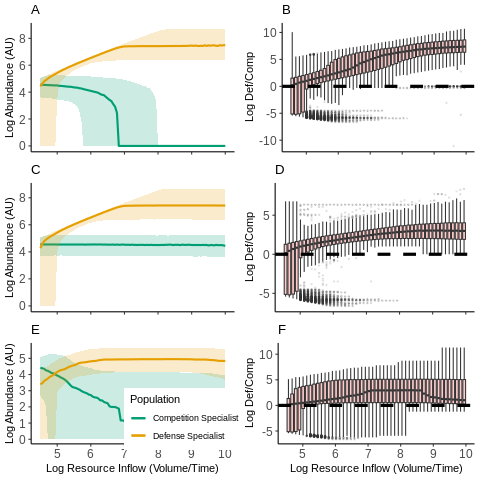

In [5]:
%%R -i df_gen,ratio_gen,df_par,ratio_par,df_mem,ratio_mem
library("ggplot2")
library("gridExtra")


custom_colorscale<-scale_colour_manual(values = c("b1" = "#009E73", "Competition Specialist"="#009E73",
                                                  "b2" = "#E69F00","Defense Specialist"="#E69F00",
                                                 "p"="#000000","General Phage"="#000000","Competition Phage"="#000000",
                                                  "Phage"="#000000","p1"="#000000",
                                                 "p2"="royalblue1","Modified Phage"="royalblue1",
                                                 "Defense Phage"="royalblue1"))

custom_linetype<-scale_linetype_manual(values = c("b1" = "solid", "Competition Specialist"="solid",
                                                  "b2" = "solid","Defense Specialist"="solid",
                                                 "p"="dashed","General Phage"="dashed",
                                                  "Phage"="dashed","p1"="dashed",
                                                 "p2"="dashed","Modified Phage"="dashed"))


g_legend<-function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) {x$name}) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)}

axis_text_size=12
sim_lim=200                      
ylowerlim = 10
yupperlim=10^7
lsize=1


ModVar<-function(df){ggplot(df,aes(x=Sr,y=Cmedian))+
  geom_ribbon(aes(ymin = Cql, ymax = Cqh),alpha=.2, fill = "#009E73")+
  geom_line(aes(color="c"),alpha=1,size=lsize)+
  geom_ribbon(aes(ymin = Dql, ymax = Dqh),alpha=.2, fill = "#E69F00")+
  geom_line(aes(y=Dmedian,color="d"),alpha=1,size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_colour_manual(guide = 'legend',name = 'Population', 
         values=c('c'='#009E73','d'='#E69F00'), 
         labels = c('Competition Specialist','Defense Specialist'))#+
  #coord_cartesian(ylim=c(ylowerlim,yupperlim))
}
      
      
RatVar<-function(ratio){ggplot(ratio, aes(x=bin_Sr, y=ratio,group=bin_Sr))+
  geom_boxplot(notch=FALSE, fill="red",outlier.size=.5,outlier.alpha=.1, alpha=0.2)+#,outlier.shape=NA,)+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  geom_hline(yintercept=1, size=1.5,linetype="dashed", color = "black")+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Def/Comp")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),axis.text.x = element_text(size=axis_text_size),
       axis.text.y = element_text(size=axis_text_size))}


A<-ModVar(df_gen)+guides(color=FALSE)+labs(title="A")+theme(axis.title.x=element_blank(),axis.text.x=element_blank())
B<-RatVar(ratio_gen)+guides(color=FALSE)+labs(title="B")+theme(axis.title.x=element_blank(),axis.text.x=element_blank())
C<-ModVar(df_par)+guides(color=FALSE)+labs(title="C")+theme(axis.title.x=element_blank(),axis.text.x=element_blank())
D<-RatVar(ratio_par)+guides(color=FALSE)+labs(title="D")+theme(axis.title.x=element_blank(),axis.text.x=element_blank())
E<-ModVar(df_mem)+theme(legend.position = c(0.75, 0.25))+labs(title="E")
F<-RatVar(ratio_mem)+labs(title="F") 
gridplt<-grid.arrange(A,B,
                      C,D,
                      E,F,
                      nrow = 3)

ggsave("figures/Model_Variance.png",plot=gridplt,width=7.5,height=10,device="png",dpi=1200)


In [10]:
def R_prep(df,extra=[]):
    dfR=get_ProducerColumns(df,extra)
    idvars=['Sr']+extra
    dfR = pd.melt(dfR,id_vars=idvars)
    dfR.columns = idvars+["NumRM","value"]
    dfR['NumRM'] = [ int(el.split('_')[-1]) for el in dfR['NumRM'] ]
    return(dfR)


def get_ProducerColumns(df,extra=[]):
    _=['Sr']+extra
    for member in list(df.columns):
        if 'P_' in member:
            _.append(member)
    df = df[_]
    return(df)

#This must be identical to partial_resistance.py
i_pr = {i:pr for i,pr in enumerate(np.around(np.arange(start=0.0,stop=1.05,step=.05),4))}
dfs=[]
path ='data/partial_r/orgRM_stacking/'
for file in os.listdir(path):
    if '.csv' in file:
        df = pd.read_csv(path+file,index_col=False)
        i = int(file.split('_')[-1].split('.')[0])
        if i_pr[i] in [.9,.5,.1]:
            df['Model'] = "Memory, pr={}".format(str(i_pr[i]))
            dfs.append(df)
        if i_pr[i] == .5:
            df_=pd.read_csv(path+file,index_col=False)
            dfmem=R_prep(df_)
# Because final abundance of Memory ~= Parallel, we will consolidate
# to ploting only the general model instead of Parallel and General
df = pd.read_csv("data/10member_General_endpoints.csv",index_col=False)
df['Model'] = "General/Parallel"
dfs.append(df)

#df = pd.read_csv("data/10member_Parallel_endpoints.csv",index_col=False)
#df['Model'] = "Parallel"
#dfs.append(df)
        
df = pd.concat(dfs)

df = get_ProducerColumns(df,['Model'])
df['total_abundance'] = df[df.columns[2:]].sum(axis=1)
df['HighestRM'] = df[df.columns[2:-1]].idxmax(axis=1)
df['HighestRM'] = [int(el.split('_')[-1]) for el in df['HighestRM']]
df_totals = df[['Sr','Model','total_abundance','HighestRM']]

df=pd.read_csv("data/10member_Parallel_endpoints.csv")
dfpar=R_prep(df)
dfpar = dfpar[dfpar['NumRM'] <4]

df=pd.read_csv("data/10member_General_endpoints.csv")
dfgen=R_prep(df)
dfgen = dfgen[dfgen['NumRM'] <4]


/home/spiridon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [11]:
set(df_totals['Model'])

{'General/Parallel', 'Memory, pr=0.1', 'Memory, pr=0.5', 'Memory, pr=0.9'}

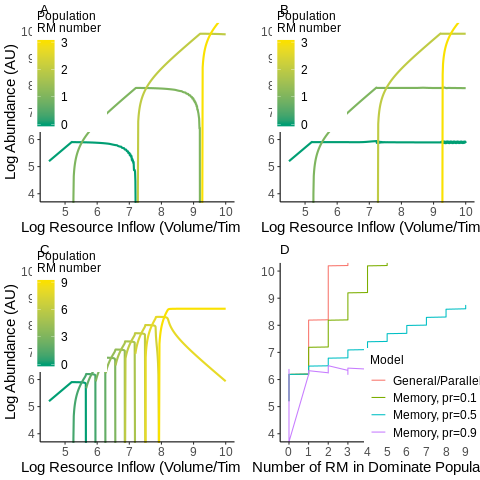

In [12]:
%%R -i dfgen,dfpar,dfmem,df_totals
library("ggplot2")
library("gridExtra")


ylowerlim = 10^4
yupperlim=10^10
lsize=1
axis_text_size=12
axis_label_size=15
legend_textsize = 12
yname = "Log Abundance (AU)"
xname = "Log Resource Inflow (Volume/Time)"


df_totals$Model <-as.factor(df_totals$Model)

set_breaks <- function(limits) {
    if ((limits[2] - limits[1]) < 5){
        x=seq(limits[1], limits[2], by = 1) 
    }
    else{
        x=seq(limits[1], limits[2], by = 3)
    }
    return(x)
}
plt_ComplexVC<-function(df){
  plt<-ggplot(df,aes(x=Sr,y=value,group=NumRM,color=NumRM))+
  geom_line(size=lsize)+
  theme_bw()+
  labs(x="Log Resource Inflow (Volume/Time)",y="Log Abundance (AU)",
       color="Population \nRM number")+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
        axis.text = element_text(size=axis_text_size),
        axis.title= element_text(size=axis_label_size),
        legend.position = c(.15,.75),
        legend.text=element_text(size=legend_textsize),
        legend.title=element_text(size=legend_textsize))+
  scale_x_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
    scale_colour_gradient(low = '#009E73',high = "#fae100",breaks = set_breaks)
    #alternate = #E69F00
  return(plt)
}


A<-plt_ComplexVC(dfgen)
B<-plt_ComplexVC(dfpar)+labs(x="Log Resource Inflow (Volume/Time)",y=" ")
C<-plt_ComplexVC(dfmem)


D<-ggplot(df_totals,aes(x=HighestRM,y=total_abundance,group=Model,color=Model))+
  geom_line()+
  scale_y_log10(
   breaks = scales::trans_breaks("log10", function(x) {10^x}),
   labels = scales::trans_format("log10", scales::math_format(.x)))+
  theme_bw()+
  theme(panel.border = element_blank(), panel.grid.minor = element_blank(),
        panel.grid.major = element_blank(),
        axis.line = element_line(color="black"),
        axis.text = element_text(size=axis_text_size),
        axis.title= element_text(size=axis_label_size),
        legend.position = c(.75,.25),
        legend.text=element_text(size=legend_textsize),
        legend.title=element_text(size=legend_textsize))+
  labs(x="Number of RM in Dominate Population",y=" ")+
  coord_cartesian(ylim=c(ylowerlim,yupperlim))+
  scale_x_continuous(limits=c(0,9),breaks=c(0,1,2,3,4,5,6,7,8,9) )
  
gridplt<-grid.arrange(A+labs(title='A'),
                      B+labs(title='B'),
                      C+labs(title='C'),
                      D+labs(title='D'),
                      nrow = 2)
ggsave('figures/Abundance_RMnum.png',plot=gridplt,width=9,height=9,device='png',dpi=900)


In [8]:
#This must be identical to partial_resistance.py
i_pr = {i:pr for i,pr in enumerate(np.around(np.arange(start=0.0,stop=1.05,step=.05),4))}
dfs=[]
paths =['data/partial_r/orgRM_unique/','data/partial_r/orgRM_mixed/','data/partial_r/orgRM_stacking/']
for path in paths:
    for file in os.listdir(path):
        if '.csv' in file:
            RMtype = path.split('_')[-1][:-1]
            df = pd.read_csv(path+file,index_col=False)
            i = int(file.split('_')[-1].split('.')[0])
            if i_pr[i] in [.9,.5,.1]:
                print(i_pr[i])
                dfs.append(df)
                            
#df=pd.concat(dfs)
u_9,u_1,u_5,m_9,m_1,m_5,s_9,s_1,s_5=[R_prep(df) for df in dfs]

#For Graphing puposes, we are removing orgs because they never enter in certian simulations
u_1 = u_1[u_1['NumRM'] < 7]
s_1 = s_1[s_1['NumRM'] < 7]

0.9
0.1
0.5
0.9
0.1
0.5
0.9
0.1
0.5


/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘lemon’


  warnings.warn(x, RRuntimeWarning)
/home/spiridon/anaconda3/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked _by_ ‘.GlobalEnv’:

    g_legend


  warnings.warn(x, RRuntimeWarning)


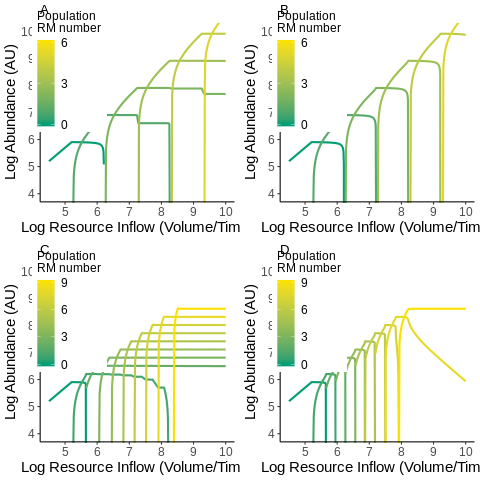

In [9]:
%%R -i u_9,u_1,u_5,m_9,m_1,m_5,s_9,s_1,s_5
library(lemon)
A<-plt_ComplexVC(u_1)
B<-plt_ComplexVC(m_1)
C<-plt_ComplexVC(s_1)
D<-plt_ComplexVC(u_5)
E<-plt_ComplexVC(m_5)
F<-plt_ComplexVC(s_5)
G<-plt_ComplexVC(u_9)
H<-plt_ComplexVC(m_9)
I<-plt_ComplexVC(s_9)

#This excludes mixed
gridplt<-grid.arrange(A+labs(title='A'),C+labs(title='B'),
                      D+labs(title='C'),F+labs(title='D'),
                      #G+labs(title='E'),I+labs(title='F'),
                      nrow = 2)


#gridplt<-grid.arrange(A+labs(title='A'),B+labs(title='B'),C+labs(title='C'),
#                      D+labs(title='D'),E+labs(title='E'),F+labs(title='F'),
#                      G+labs(title='G'),H+labs(title='H'),I+labs(title='I'),
#                      nrow = 3)

ggsave('figures/U_S.png',plot=gridplt,width=9,height=12,device='png',dpi=900)
